# Facial Expression Recognition Project

## Library Installations and Imports

In [1]:
!pip install -U -q PyDrive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install -q keras


from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydot

import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Dense
from keras.layers import Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical
from keras import backend as K


Selecting previously unselected package fontconfig.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpacking libwebp6:amd

Setting up libgraphite2-3:amd64 (1.3.10-2) ...
Setting up libpixman-1-0:amd64 (0.34.0-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 

Using TensorFlow backend.


### Confirm Tensorflow and GPU Support

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5167509442147658940, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 356122624
 locality {
   bus_id: 1
 }
 incarnation: 7667719606676113484
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Helper Functions

In [0]:
def uploadFiles():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  filenames = list(uploaded.keys())
  for f in filenames:
    data = str(uploaded[f], 'utf-8')
    file = open(f, 'w')
    file.write(data)
    file.close()

def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label

def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

## Import FER2013 Dataset and Other Files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fer2013 = drive.CreateFile({'id':'1Xdlvej7eXaVcfCf3CsQ1LcSFAiNx_63c'})

In [0]:
fer2013.GetContentFile('fer2013file.csv')

Save file as a pandas dataframe.

In [0]:
df = pd.read_csv('fer2013file.csv')

## Parse Data

Each image is a 48 x 48 grayscale photo.

The contents of pixel string are space-separated pixel values in row major order.

Emotional assignment convention:


*   0 = Angry
*   1 = Disgust
*   2 = Fear
*   3 = Happy
*   4 = Sad
*   5 = Surprise
*   6 = Neutral


In [0]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [11]:
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(img_train[0][0][0][0])) + '\t' + str(img_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(img_train[0][0][0][0])) + '\t' + 
      str(img_test.shape))
print('Type and Shape of Image Datasets: ' + '\n\tTraining: ' + '\t' + 
      str(type(lbl_train[0][0])) + '\t' + str(lbl_train.shape) + 
      '\n\tTesting: ' + '\t' + str(type(lbl_train[0][0])) + '\t' + 
      str(lbl_test.shape))

Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 48, 48, 1)
	Testing: 	<class 'numpy.uint8'>	(3589, 48, 48, 1)
Type and Shape of Image Datasets: 
	Training: 	<class 'numpy.uint8'>	(28709, 7)
	Testing: 	<class 'numpy.uint8'>	(3589, 7)


### Save Data to .npy Files

In [0]:
#np.save('img_train.npy', img_train)
#np.save('lbl_train.npy', lbl_train)
#np.save('img_test.npy', img_test)
#np.save('lbl_test.npy', img_test)

### Verify Image Import

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

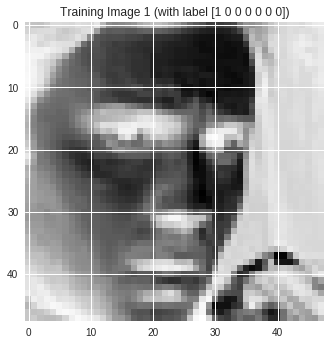

In [12]:
plt.imshow(np.reshape(img_train[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_train[0]) + ')')

Text(0.5,1,'Training Image 1 (with label [1 0 0 0 0 0 0])')

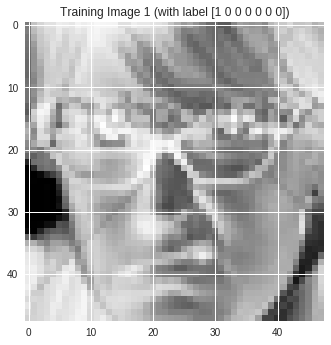

In [13]:
plt.imshow(np.reshape(img_test[0], (48,48)))
plt.title('Training Image 1 (with label ' + str(lbl_test[0]) + ')')

## Build Convolutional Neural Network Model


In [0]:
model = Sequential()

### Phase 1
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 32**
- **Stride: 1 (default)**
- **Active Padding**

In [27]:
outputFilters = 32
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu',
                 input_shape=img_train[0].shape))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


### Phase 2
- Convolutional and Max Pooling Phase.
- **Kernal Size: 3x3**
- **Ouput Filters: 64**
- **Stride: 1 (default)**
- **Active Padding**


In [28]:
outputFilters = 64
kernelSize = 3 

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        36928     
Total para

### Phase 3
- Locally-Connected Convlutional Filtering Phase.
  - The locally-connected layer works similarly to the traditional 2D convolutional layer, except that weights are unshared, that is, a different set of filters is applied at each different patch of the input.
- **Ouput Filters: 32**
- **Kernal Size: 4x4**
- **Stride: 1 (default)**
- **Non-Active Padding**

In [29]:
outputFilters = 32
kernelSize = 4

model.add(LocallyConnected2D(outputFilters, kernelSize, padding='valid', 
                             activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        36928     
__________

### Level 4

- Size of Convolutional Template Filter: 3 x 3 pixels
- Size of Template Stride: 3 pixels (for both horizontal and vertical stride)
- Number of output filters in the convolution: 128
- Padding protocol: Output is same dimensions as original image.

In [30]:
outputFilters = 128
kernelSize = 3

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        36928     
__________

### Dense Layers

In [31]:
layerSize = 64
dropoutRate = 0.5

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        36928     
__________

### Show Model Structure

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

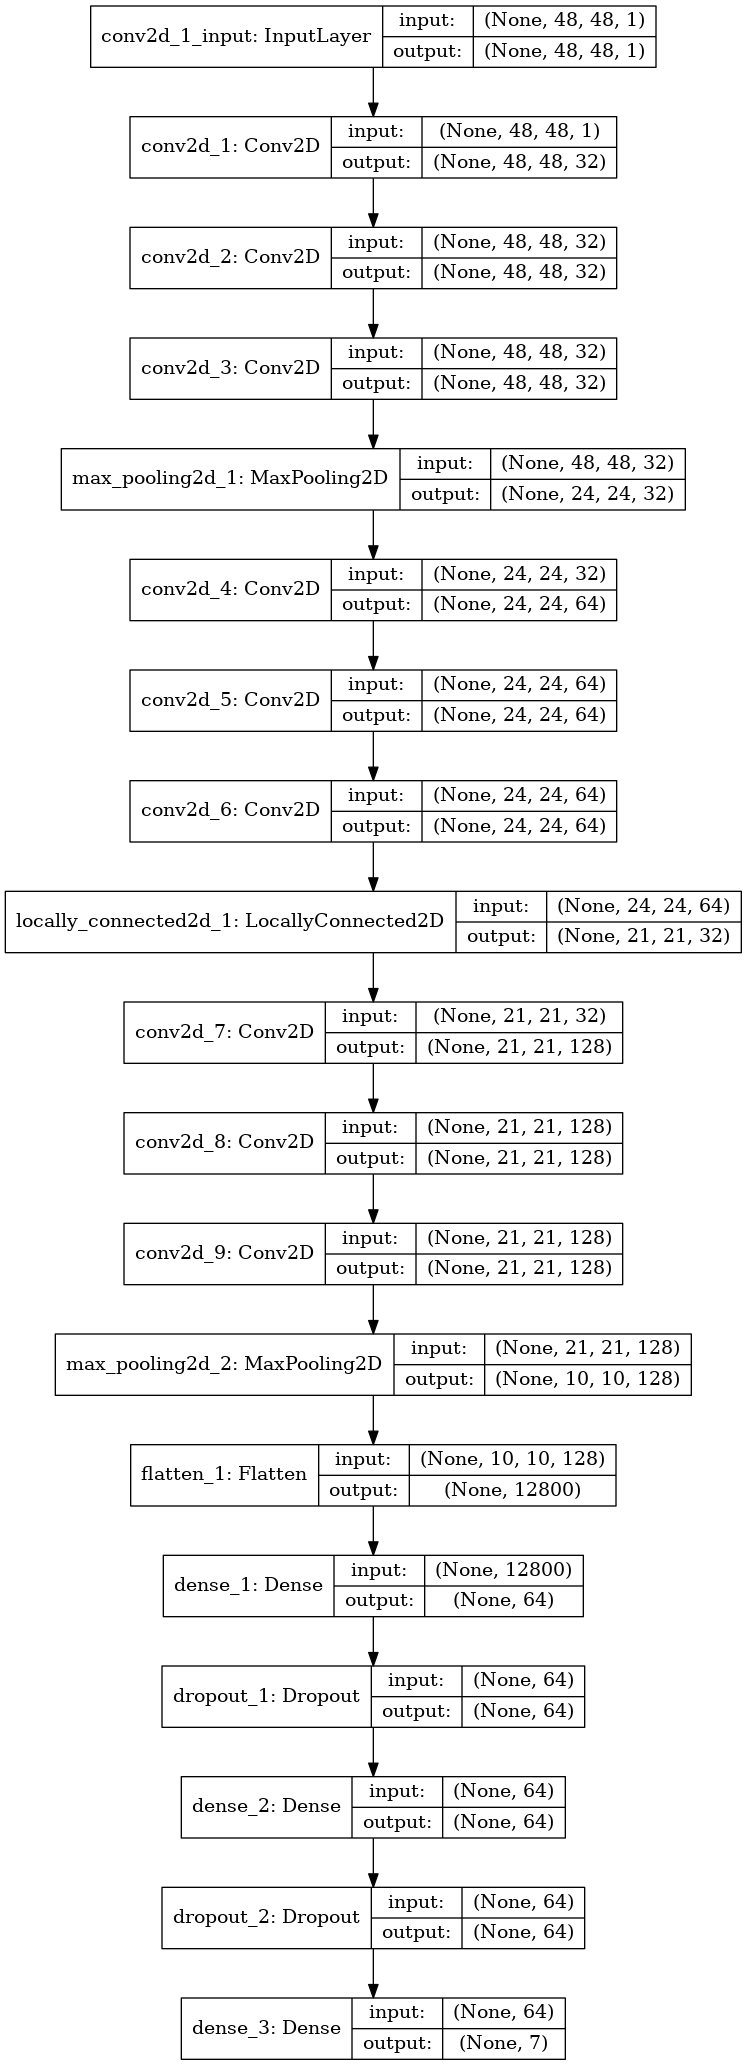

In [20]:
from IPython.display import Image
Image(filename='model.png') 

## Compile, Train, and Evaluate the Model

In [21]:
batchSize = 128
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,
                            validation_split=0.3, 
                            callbacks=[early_stopping], 
                            shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']
print("Done Training: ")
print('Final Training Accuracy: ', trainingAccuracy[-1])
print('Final Validation Accuracy: ', validationAccuracy[-1])
print('Overfit Ratio: ', validationAccuracy[-1]/trainingAccuracy[-1])

metrics = model.evaluate(img_test, lbl_test, batch_size=batchSize, verbose=1)
print('Evaluation Loss: ', metrics[0])
print('Evaluation Accuracy: ', metrics[1])

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 67s 3ms/step - loss: 1.8671 - acc: 0.2328 - val_loss: 1.7924 - val_acc: 0.2529
Epoch 2/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.7607 - acc: 0.2547 - val_loss: 1.7226 - val_acc: 0.2529
Epoch 3/50
 9984/20096 [=============>................] - ETA: 28s - loss: 1.7026 - acc: 0.2925

20096/20096 [==============================] - 61s 3ms/step - loss: 1.6848 - acc: 0.3024 - val_loss: 1.6278 - val_acc: 0.3485
Epoch 4/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.6321 - acc: 0.3268 - val_loss: 1.5866 - val_acc: 0.3575
Epoch 5/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.6013 - acc: 0.3375 - val_loss: 1.5976 - val_acc: 0.3538
Epoch 6/50
  384/20096 [..............................] - ETA: 55s - loss: 1.5226 - acc: 0.3255

20096/20096 [==============================] - 61s 3ms/step - loss: 1.5684 - acc: 0.3460 - val_loss: 1.5540 - val_acc: 0.3525
Epoch 7/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.5155 - acc: 0.3696 - val_loss: 1.5451 - val_acc: 0.3600
Epoch 8/50
18432/20096 [==========================>...] - ETA: 4s - loss: 1.4675 - acc: 0.3850

20096/20096 [==============================] - 61s 3ms/step - loss: 1.4713 - acc: 0.3832 - val_loss: 1.5249 - val_acc: 0.3747
Epoch 9/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.4289 - acc: 0.4033 - val_loss: 1.5058 - val_acc: 0.3780
Epoch 10/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.3865 - acc: 0.4171 - val_loss: 1.4988 - val_acc: 0.3737
Epoch 11/50
 1664/20096 [=>............................] - ETA: 51s - loss: 1.3285 - acc: 0.4333

20096/20096 [==============================] - 61s 3ms/step - loss: 1.3423 - acc: 0.4328 - val_loss: 1.4928 - val_acc: 0.4150
Epoch 12/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.2798 - acc: 0.4574 - val_loss: 1.5389 - val_acc: 0.4078
Epoch 13/50
18560/20096 [==========================>...] - ETA: 4s - loss: 1.2310 - acc: 0.4742

20096/20096 [==============================] - 61s 3ms/step - loss: 1.2356 - acc: 0.4731 - val_loss: 1.5534 - val_acc: 0.4192
Epoch 14/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.1857 - acc: 0.4924 - val_loss: 1.5402 - val_acc: 0.4047
Epoch 15/50
20096/20096 [==============================] - 61s 3ms/step - loss: 1.1025 - acc: 0.5181 - val_loss: 1.5816 - val_acc: 0.4035
Epoch 16/50
 1664/20096 [=>............................] - ETA: 52s - loss: 1.0545 - acc: 0.5282

20096/20096 [==============================] - 61s 3ms/step - loss: 1.0714 - acc: 0.5198 - val_loss: 1.6038 - val_acc: 0.3674
Epoch 00016: early stopping
Done Training: 
Final Training Accuracy:  0.5197551751592356
Final Validation Accuracy:  0.36735167768266463
Overfit Ratio:  0.7067782972437366
3589/3589 [==============================] - 2s 614us/step
Evaluation Loss:  1.6529341632524683
Evaluation Accuracy:  0.360267483987128
